# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window

from pyspark.sql.functions import udf, sum as Fsum, desc, asc, countDistinct, col, to_date, year, month, dayofmonth, minute, hour, datediff, min, max

from pyspark.sql.types import IntegerType, DateType, TimestampType, StringType

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import datetime

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### Exploratory Data Analysis

In [4]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
print(user_log.take(1))

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]


In [6]:
print("Number of rows in dataset: {}".format(user_log.count())) 

Number of rows in dataset: 286500


In [28]:
for column in user_log.columns:
    print("Analysis of column {}".format(column))
    print("Statistical properties:")
    print(user_log.describe(column).show())
    print("\nCount of unique values in column:")
    print(user_log.select(countDistinct(column)).show(),"\n")

Analysis of column artist
Statistical properties:
+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+

None

Count of unique values in column:
+----------------------+
|count(DISTINCT artist)|
+----------------------+
|                 17655|
+----------------------+

None 

Analysis of column auth
Statistical properties:
+-------+----------+
|summary|      auth|
+-------+----------+
|  count|    286500|
|   mean|      null|
| stddev|      null|
|    min| Cancelled|
|    max|Logged Out|
+-------+----------+

None

Count of unique values in column:
+--------------------+
|count(DISTINCT auth)|
+--------------------+
|                   4|
+--------------------+

None 

Analysis of column firstName
Statistical properties:
+-------+---------+
|summary|firstName|
+-------+---------+
|

### Findings of descriptive statistics on data sample per feature: ###
* Summary per feature:
    * auth: no missing values; 4 distinct values. 
        * follow-up: check if missing values relate to value "Logged Out"
    * artist: few missing values; 17655 distinct values.
    * song: few missing values; 58480 distinct values.
    * userID: no missing values; 226 distinct values.
    * firstName: few missing values; 189 distinct values.
    * LastName: few missing values; 173 distinct values.
    * gender: few missing values; 2 distinct values.
    * ItemInSession: no missing values; 1322 distinct values.
        * follow-up: analyse meaning on example of one user
    * length: few missing values; 14865 distinct values.
        * follow-up: analyse meaning on example of one user
    * level: no missing values; 2 distinct values.
    * location: few missing values; 114 distinct values
        * follow-up: analyse user locations according to Country, State, etc
    * method: no missing values; 2 distinct values.
        * follow-up: analyse meaning on example of one user
    * page: no missing values; 22 distinct values.
    * registration: few missing values; 225 distinct values.
        * relates to 226 unique userID's minus empty name
        * format equals timestamp -> follow-up: convert to time/date
    * sessionID: few missing values; 2354 distinct values.
        * follow-up: analyse meaning on example of one user
    * status: no missing values; 3 distinct values.
    * ts: no missing values; 277447 unique values.
        * follow-up: conversion to date/ time
        * follow-up: analyse spread of date/ time
        * follow-up: further conversion to features for year/ month/ time
    * userAgent: few missing values; 56 distinct values
        * follow-up: further analyse values and value distribution

* Follow-up summary:
    1. "auth": check if missing values relate to value "Logged Out"
    2. analyse meaning on example of one user:
        * list = ["ItemInSession", "length", "method", "sessionID"]
    3. print categorical features with low cardinality (less than 56 distinct values):
        * list = ["auth", "gender", "level", "method", "page", "status", "userAgent"]
        * value name and value counts
    4. "location": analyse user locations according to Country, State, etc
    * convert to time/date:
        * list = ["registration", "ts"]
    5. "ts": analyse spread of date/ time
    6. "ts": further conversion to features for year/ month/ time

#### (1) "auth": check if missing values relate to value "Logged Out"

In [45]:
# (1) check if missing values relate to value "Logged Out"
auth_values = user_log.select("auth").distinct().rdd.map(lambda r: r[0]).collect()
for value in auth_values:
    print("null values in rows with auth value {}:".format(value))
    value_df = user_log.filter(user_log["auth"] == value)
    missing_value_columns = ['artist',
                             'firstName',
                             'gender',
                             'lastName',
                             'length',
                             'location',
                             'registration',
                             'song',
                             'userAgent']
    for column in missing_value_columns:
        print("column {} : {}".format(column, value_df.filter(value_df[column].isNull()).count()))

null values in rows with auth value Logged Out:
column artist : 8249
column firstName : 8249
column gender : 8249
column lastName : 8249
column length : 8249
column location : 8249
column registration : 8249
column song : 8249
column userAgent : 8249
null values in rows with auth value Cancelled:
column artist : 52
column firstName : 0
column gender : 0
column lastName : 0
column length : 52
column location : 0
column registration : 0
column song : 52
column userAgent : 0
null values in rows with auth value Guest:
column artist : 97
column firstName : 97
column gender : 97
column lastName : 97
column length : 97
column location : 97
column registration : 97
column song : 97
column userAgent : 97
null values in rows with auth value Logged In:
column artist : 49994
column firstName : 0
column gender : 0
column lastName : 0
column length : 49994
column location : 0
column registration : 0
column song : 49994
column userAgent : 0


In [48]:
print("Value counts of distinct values in feature auth:")
user_log.groupBy("auth").count().orderBy("count").show()

Value counts of distinct values in feature auth:
+----------+------+
|      auth| count|
+----------+------+
| Cancelled|    52|
|     Guest|    97|
|Logged Out|  8249|
| Logged In|278102|
+----------+------+



In [62]:
print("Analyse page counts where users are logged in and feature artist has missing values:")
user_log.filter((user_log["auth"]=="Logged In")&(user_log["artist"].isNull())).groupBy("page").count().orderBy("count").show()

Analyse page counts where users are logged in and feature artist has missing values:
+----------------+-----+
|            page|count|
+----------------+-----+
|          Cancel|   52|
|Submit Downgrade|   63|
|  Submit Upgrade|  159|
|           Error|  252|
|   Save Settings|  310|
|           About|  495|
|         Upgrade|  499|
|            Help| 1454|
|        Settings| 1514|
|       Downgrade| 2055|
|     Thumbs Down| 2546|
|          Logout| 3226|
|     Roll Advert| 3933|
|      Add Friend| 4277|
| Add to Playlist| 6526|
|            Home|10082|
|       Thumbs Up|12551|
+----------------+-----+



In [63]:
print("Analyse page counts where users are logged in and feature artist has NO missing values:")
user_log.filter((user_log["auth"]=="Logged In")&(user_log["artist"].isNotNull())).groupBy("page").count().orderBy("count").show()

Analyse page counts where users are logged in and feature artist has NO missing values:
+--------+------+
|    page| count|
+--------+------+
|NextSong|228108|
+--------+------+



In [19]:
print("Analyse value count of Roll Advert depending on level value:")
user_log_valid.filter(user_log_valid["page"]=="Roll Advert").groupBy("level").count().show()

Analyse value count of Roll Advert depending on level value:
+-----+-----+
|level|count|
+-----+-----+
| free| 3687|
| paid|  246|
+-----+-----+



#### Findings on (1):
* "auth" value "Cancelled" correlates to "page" value "Cancellation Confirmed".
* "auth" value "Guest" does not have any relevant information on users and can for churn use case be dropped.
    * follow-up: drop corresponding rows (user_log["auth"]=="Guest")
* "auth" value "Logged Out" does not have any relevant information on users and can for churn use case be dropped.
    * follow-up: drop corresponding rows (user_log["auth"]==""Logged Out"") 
* "auth" values "Logged In" has no missing artist values at page value "NextSong" (ca  72% in sample data set).
    * interpretation: users are in this cases listenting to music.
* "auth" values "Logged In" has missing artist values at all other pages (ca 18%in sample data set).
    * interpretation: users are in this cases not listenting to music, but doing other transactions

## Remove auth values "Guest" and "Logged Out" from Dataset

In [4]:
user_log_valid = user_log.filter(user_log["auth"].isin(*["Guest", "Logged Out"]) == False)

#### (2) analyse meaning on example of one user: ####
list = ["ItemInSession", "length", "method", "sessionID"]

Findings:
* number of items per "sessionId" does not equal values in "ItemInSession"
* "method" appear to refer to user interaction. Interpretation:
    * PUT: action by user. Therefore PUT data should be furhter analyzed.
    * GET: reaction to user
* "lenght" refers to song length
* "sessionID": values are not unique. 
    * Several users can share the same session Id.
    * an examplary analysis showed not direct relation between users that share the same sessionId

In [79]:
# Analyze feature method
pd_method_df = user_log_valid.groupBy(["method","page"]).count().orderBy(["method","count"]).toPandas()
pd_method_df

,method,page,count
0,GET,Cancellation Confirmation,52
1,GET,Error,252
2,GET,About,495
3,GET,Upgrade,499
4,GET,Help,1454
5,GET,Settings,1514
6,GET,Downgrade,2055
7,GET,Roll Advert,3933
8,GET,Home,10082
9,PUT,Cancel,52


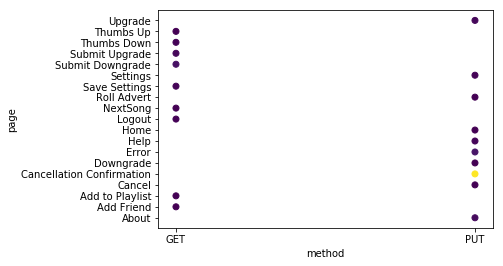

In [80]:
plt.scatter(pd_method_df["method"], pd_method_df["page"].sort_index(ascending=False), c=pd_method_df["count"], cmap='viridis')
plt.xlabel("method")
plt.ylabel("page");

In [85]:
# analyze length
user_log_valid.select(["song", "length"]).distinct().take(5)

[Row(song="She's Mine", length=271.51628),
 Row(song='Nossa Senhora Do Tejo', length=287.4771),
 Row(song='So Lonely', length=287.81669),
 Row(song='Face Down (Album Version)', length=191.84281),
 Row(song='Lonely Summer Nights', length=199.13098)]

In [92]:
# analyze sessionId
print("Maximum value count for one Id in Session Id:")
print(user_log_valid.groupBy("sessionId").count().orderBy("count").agg({"count": "max"}).collect()[0][0])
pd_sessionid_df = user_log_valid.groupBy("sessionId").count().orderBy("count").toPandas()
pd_sessionid_df.describe()

Maximum value count for one Id in Session Id:
1282


,sessionId,count
count,2312.000000,2312.000000
mean,1183.699394,120.308824
std,690.855976,134.407683
min,1.000000,1.000000
25%,584.750000,28.000000
50%,1177.500000,72.000000
75%,1776.250000,169.000000
max,2474.000000,1282.000000


In [128]:
# Analyze count of unique userId's per sessionId
print("Count of unique userId's per sessionId:")
user_log_valid.groupBy(["sessionId", "userId"]).count().orderBy(["sessionId", "userId"]).groupBy("sessionId").count().orderBy("count").describe().show()

Count of unique userId's per sessionId:
+-------+------------------+------------------+
|summary|         sessionId|             count|
+-------+------------------+------------------+
|  count|              2312|              2312|
|   mean|1183.6993944636679|1.3737024221453287|
| stddev| 690.8559764013388|0.8037991538528159|
|    min|                 1|                 1|
|    max|              2474|                 4|
+-------+------------------+------------------+



In [119]:
# convert to pandas series for further analysis
pd_usercount_per_sessionid_df = user_log_valid.groupBy(["sessionId", "userId"]).count().orderBy(["sessionId", "userId"]).groupBy("sessionId").count().orderBy("count").toPandas()

In [130]:
# get examples of sessionId's that share same Id for 4 users
pd_usercount_per_sessionid_df[pd_usercount_per_sessionid_df["count"]==4].head()

,sessionId,count
2234,65,4
2235,54,4
2236,112,4
2237,113,4
2238,167,4


In [132]:
# analyze sessionId 65 further...
user_log_valid.filter(user_log_valid["sessionId"]==65).groupBy("userId").count().orderBy("count").show()

+------+-----+
|userId|count|
+------+-----+
|200021|   10|
|    66|   15|
|100013|   73|
|300023|  270|
+------+-----+



In [135]:
# select userId's "200021", "66" for further analysis

pd_df = user_log_valid.filter((user_log_valid["sessionId"]==65) & (user_log_valid["userId"].isin(*["200021", "66"]))).toPandas()
pd_df

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Bersuit Vergarabat,Logged In,Alyssa,F,0,Johnston,236.98240,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,NextSong,1532634173000,65,La logia (iambo-iombo),200,1538682135000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,66
1,None,Logged In,Alyssa,F,1,Johnston,NaN,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,Logout,1532634173000,65,None,307,1538682136000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,66
2,None,Logged In,Alyssa,F,4,Johnston,NaN,free,"Los Angeles-Long Beach-Anaheim, CA",GET,Home,1532634173000,65,None,200,1538682221000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,66
3,Queens Of The Stone Age,Logged In,Alyssa,F,5,Johnston,192.46975,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,NextSong,1532634173000,65,You Think I Ain't Worth A Dollar_ But I Feel L...,200,1538682371000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,66
4,She & Him,Logged In,Alyssa,F,6,Johnston,153.52118,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,NextSong,1532634173000,65,Why Do You Let Me Stay Here?,200,1538682563000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,66
5,Bumblefoot,Logged In,Alyssa,F,7,Johnston,246.77832,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,NextSong,1532634173000,65,Green,200,1538682716000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,66
6,Madlib The Beat Konducta,Logged In,Alyssa,F,8,Johnston,92.29016,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,NextSong,1532634173000,65,Life,200,1538682962000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,66
7,Evanescence,Logged In,Alyssa,F,9,Johnston,247.35302,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,NextSong,1532634173000,65,My Last Breath,200,1538683054000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,66
8,Babyshambles,Logged In,Alyssa,F,10,Johnston,214.88281,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,NextSong,1532634173000,65,There She Goes,200,1538683301000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,66
9,Dilated Peoples,Logged In,Alyssa,F,11,Johnston,236.59057,free,"Los Angeles-Long Beach-Anaheim, CA",PUT,NextSong,1532634173000,65,World On Wheels,200,1538683515000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,66


#### (3) print categorical features with low cardinality (less than 56 distinct values): ####
list = ["auth", "gender", "level", "method", "page", "status", "userAgent"]
value name and value counts

In [152]:
for column in ["auth", "gender", "level", "method", "page", "status", "userAgent"]:
    print(user_log_valid.groupBy(column).count().orderBy("count").show()); 

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278102|
+---------+------+

None
+------+------+
|gender| count|
+------+------+
|     M|123576|
|     F|154578|
+------+------+

None
+-----+------+
|level| count|
+-----+------+
| free| 55721|
| paid|222433|
+-----+------+

None
+------+------+
|method| count|
+------+------+
|   GET| 20336|
|   PUT|257818|
+------+------+

None
+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|Cancellation Conf...|    52|
|    Submit Downgrade|    63|
|      Submit Upgrade|   159|
|               Error|   252|
|       Save Settings|   310|
|               About|   495|
|             Upgrade|   499|
|                Help|  1454|
|            Settings|  1514|
|           Downgrade|  2055|
|         Thumbs Down|  2546|
|              Logout|  3226|
|         Roll Advert|  3933|
|          Add Friend|  4277|
|     Add to Playlist|  6526|
|         

In [159]:
# detailled analysis of feature "userAgent"
pd_df = user_log_valid.groupBy("userAgent").count().orderBy("count").toPandas()
print(pd_df["userAgent"].tolist())
pd_df["count"].describe()

['Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36"', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; rv:31.0) Gecko/20100101 Firefox/31.0', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', '"Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2) AppleWebKit/537.75.14 (KHTML, like Gecko) Version/7.0.3 Safari/537.75.14"', '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5) AppleWebKit/537.77.4 (KHTML, like Gecko) Ver

count       56.000000
mean      4967.035714
std       5602.901751
min         62.000000
25%       1257.750000
50%       2506.500000
75%       6718.750000
max      22751.000000
Name: count, dtype: float64

In [157]:
# further analysis of relationship between page and status...
user_log_valid.groupBy(["status", "method", "page"]).count().orderBy("status", "method", "count").show()

+------+------+--------------------+------+
|status|method|                page| count|
+------+------+--------------------+------+
|   200|   GET|Cancellation Conf...|    52|
|   200|   GET|               About|   495|
|   200|   GET|             Upgrade|   499|
|   200|   GET|                Help|  1454|
|   200|   GET|            Settings|  1514|
|   200|   GET|           Downgrade|  2055|
|   200|   GET|         Roll Advert|  3933|
|   200|   GET|                Home| 10082|
|   200|   PUT|     Add to Playlist|  6526|
|   200|   PUT|            NextSong|228108|
|   307|   PUT|              Cancel|    52|
|   307|   PUT|    Submit Downgrade|    63|
|   307|   PUT|      Submit Upgrade|   159|
|   307|   PUT|       Save Settings|   310|
|   307|   PUT|         Thumbs Down|  2546|
|   307|   PUT|              Logout|  3226|
|   307|   PUT|          Add Friend|  4277|
|   307|   PUT|           Thumbs Up| 12551|
|   404|   GET|               Error|   252|
+------+------+-----------------

#### Findings on (3) ####
* "status": refers to html status codes (https://en.wikipedia.org/wiki/List_of_HTTP_status_codes)
    * 200: page ok
    * 307: Temporary redirect
    * 404: error
* "userAgent": needs to be split up into further features for analysis, e.g. influence of operating system

#### (4) "location": analyse user locations according to Country, State, etc ####

In [174]:
pd_df = user_log_valid.groupBy("location", "userID").count().orderBy("count").toPandas()
pd_df["CSA"] = pd_df["location"].apply(lambda loc_string: loc_string.split(", ")[1])
print("number of unique Combined Statistical Areas in sample data: {}".format(pd_df["CSA"].nunique()))
pd_df.describe()

number of unique Combined Statistical Areas in sample data: 58


,count
count,225.000000
mean,1236.240000
std,1329.531716
min,6.000000
25%,296.000000
50%,848.000000
75%,1863.000000
max,9632.000000


In [176]:
# evaluate user dataset row distribution over CSA
pd_CSA_count = pd.pivot_table(pd_df, values = ["userID","count"], index="CSA", aggfunc={
    "userID": "count",
    "count": np.sum})
pd_CSA_count.sort_values(by = ["count", "userID"], ascending = False)

,count,userID
CSA,,
CA,46771,33
NY-NJ-PA,23684,15
TX,23494,16
MA-NH,13873,5
FL,13190,14
NC,10688,6
NC-SC,7780,6
CO,7493,4
MI,7216,5


####  (5) convert to time/date: ####
list = ["registration", "ts"]

In [5]:
def convert_ts_to_datetime(df, column_list):
    get_datetime = udf(lambda timestamp: datetime.datetime.fromtimestamp(timestamp/1000).isoformat())
    for column in column_list:
        df = df.withColumn(column + "_timestamp", get_datetime(df[column]).cast(TimestampType()))
    return df

In [6]:
column_list = ["registration", "ts"]
user_log_valid = convert_ts_to_datetime(user_log_valid, column_list)

In [8]:
user_log_valid.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- registration_timestamp: timestamp (nullable = true)
 |-- ts_timestamp: timestamp (nullable = true)



#### (6.1) "ts": analyse spread of date/ time

In [9]:
min_date, max_date = user_log_valid.select(min("ts_timestamp"), max("ts_timestamp")).first()
min_date, max_date

(datetime.datetime(2018, 10, 1, 0, 1, 57),
 datetime.datetime(2018, 12, 3, 1, 11, 16))

Analyze log data over time:


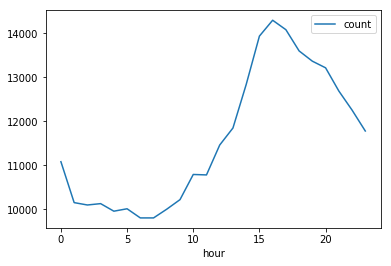

In [85]:
print("Analyze log data over time:")
pd_df = user_log_valid.select(hour("ts_timestamp").alias("hour")).groupBy("hour").count().orderBy("hour").toPandas()
pd_df.plot.line(x="hour", y="count");

#### (6.1) "registration": analyse spread of date/ time

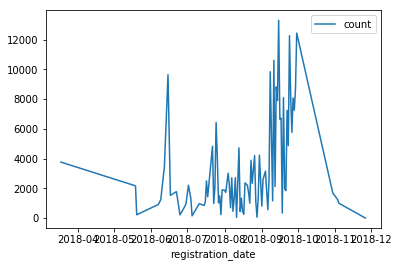

In [7]:
pd_df = user_log_valid.select(to_date("registration_timestamp").alias("registration_date")).groupBy("registration_date").count().orderBy("registration_date").toPandas()
pd_df.plot.line(x="registration_date", y="count");

#### "ts": further conversion to features for year/ month/ time

In [8]:
user_log_valid = user_log_valid.withColumn("ts_hour", hour("ts_timestamp"))

# Data Cleaning

In [9]:
# remove missing and null values
#user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])
#user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")
#user_log_valid.count()

# resulting count: 278154

278154

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

## Features from "page" value ##

In [9]:
print("page values with user action put:")
user_log_valid.filter(user_log_valid["method"]=="PUT").groupBy("page").count().orderBy("count").show()   

page values with user action put:
+----------------+------+
|            page| count|
+----------------+------+
|          Cancel|    52|
|Submit Downgrade|    63|
|  Submit Upgrade|   159|
|   Save Settings|   310|
|     Thumbs Down|  2546|
|          Logout|  3226|
|      Add Friend|  4277|
| Add to Playlist|  6526|
|       Thumbs Up| 12551|
|        NextSong|228108|
+----------------+------+



### Selection of page values for new features:
* "churn" from "Cancel"
* "downgraded" from "Submit Downgrad"
* ...

In [9]:
# define flag downgrade event lambda function
flag_downgrade_event = udf(lambda page: 1 if page == "Submit Downgrade" else 0, IntegerType())
user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [10]:
# define feature "churn"
flag_churn_event = udf(lambda page: 1 if page == "Cancel" else 0, IntegerType())
user_log_valid = user_log_valid.withColumn("churn", flag_churn_event("page"))

In [11]:
# define feature "upgrade"
flag_upgrade_event = udf(lambda page: 1 if page == "Submit Upgrade" else 0, IntegerType())
user_log_valid = user_log_valid.withColumn("upgraded", flag_upgrade_event("page"))

### Descriptive analysis on features "downgraded", "upgraded" and "churn"

In [12]:
print("Descriptive Analysis of userId's that churned, downgraded or upgraded")
pd_df= user_log_valid.select("userId", "churn", "downgraded", "upgraded").filter((user_log_valid["churn"]==1) | (user_log_valid["downgraded"]==1) | (user_log_valid["upgraded"]==1)).toPandas()
print("value count of downgraded/ upgraded where churn=0")
value_count = pd_df.pivot_table(index="churn", values=[ "userId", "downgraded", "upgraded"], aggfunc={
    "userId": "count",
    "downgraded": np.sum,
    "upgraded": np.sum
})
value_count

Descriptive Analysis of userId's that churned, downgraded or upgraded
value count of downgraded/ upgraded where churn=0


,downgraded,upgraded,userId
churn,,,
0,63,159,222
1,0,0,52


## Ideas for other features
* per user: time from registration to last log action
* existing categorical features with low number of distinct values
* user interaction over time (number of songs...)
* tbd

# Old code - start +++++++++++++++++++++++

In [13]:
test=user_log_valid

In [17]:
pd_df = test.filter(test["churn"]==1).groupBy("userId").count().orderBy("count").toPandas()
pd_df["count"].value_counts()

1    52
Name: count, dtype: int64

In [12]:
# define phase "churn"
windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)
user_log_valid = user_log_valid.withColumn("churn_phase", Fsum("churn").over(windowval))
# define phase "churn"
#windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
user_log_valid = user_log_valid.withColumn("downgraded_phase", Fsum("downgraded").over(windowval))

In [13]:
user_log_valid.select(["userId", "firstname", "ts", "page", "level", "downgraded_phase", "churn_phase"]).where((user_log_valid.churn_phase == "1") & (user_log_valid.downgraded_phase == "1")).take(3)

[Row(userId='54', firstname='Alexi', ts=1542051577000, page='Cancel', level='paid', downgraded_phase=1, churn_phase=1),
 Row(userId='54', firstname='Alexi', ts=1542051608000, page='Cancellation Confirmation', level='paid', downgraded_phase=1, churn_phase=1),
 Row(userId='100025', firstname='London', ts=1540298979000, page='Cancel', level='free', downgraded_phase=1, churn_phase=1)]

In [14]:
user_54_pd = user_log_valid.select(["userId", "firstname", "ts", "page", "level", "downgraded_phase", "churn_phase"]).where((user_log_valid.userId == "54")).sort("ts").toPandas()

In [15]:
user_54_pd["level"].value_counts()

paid    2859
free     578
Name: level, dtype: int64

In [16]:
user_54_pd["level"].describe()

count     3437
unique       2
top       paid
freq      2859
Name: level, dtype: object

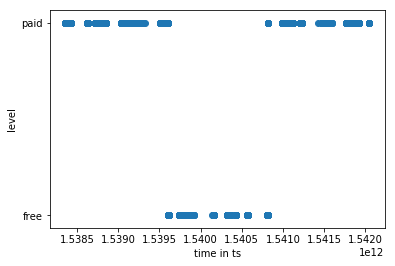

In [17]:
plt.scatter(user_54_pd["ts"], user_54_pd["level"])
#plt.xlim(-1, 24);
#plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("time in ts")
plt.ylabel("level");

# Old code - end +++++++++++++++++++++++

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [18]:
#user_log_valid.persist()
training, test, validation = user_log_valid.randomSplit([0.8, 0.1, 0.1], seed=42)

In [19]:
# build pipeline


In [20]:
# tune model


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.